# ДОМАШНЕЕ ЗАДАНИЕ: КЛАССИФИКАЦИЯ СЕРДЕЧНЫХ ЗАБОЛЕВАНИЙ
### Формулировка задачи
* Датасет: muhrafli/heart-diseases
* https://huggingface.co/datasets/muhrafli/heart-diseases

### Описание:

* 918 записей о пациентах.
* Признаки: Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope.
* Целевая переменная: булевый переменная HeartDisease (есть заболевание или нет).
### Задача:
По описанию пациента предсказать есть заболевание или нет.

* Тип задачи: классификация (делим на больных и здоровых).
* Метрики: Accuracy, F1-macro.
### Пользовательский сценарий:
Есть данные обследования пациента, нужно понять болеет он или нет, чтобы назначить более подробное обследование сердца и лечение.

In [1]:
# Установка библиотек (если нужно)
!pip install -q datasets seaborn pandas matplotlib scikit-learn numpy

# Импорты
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

# Настройка графиков
sns.set_theme(context="talk", style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("=== ДОМАШНЕЕ ЗАДАНИЕ: КЛАССИФИКАЦИЯ СЕРДЕЧНЫХ ЗАБОЛЕВАНИЙ ===\n")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\Kotenka\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== ДОМАШНЕЕ ЗАДАНИЕ: КЛАССИФИКАЦИЯ СЕРДЕЧНЫХ ЗАБОЛЕВАНИЙ ===



In [2]:
# ================================================================
# БЛОК 1. ЗАГРУЗКА ДАТАСЕТА И ПЕРВИЧНЫЙ ОСМОТР
# ================================================================

# Загрузка датасета
dataset_dict = load_dataset("muhrafli/heart-diseases")

# Сводка по сплитам
print("Сплиты и количество объектов:", {split_name: len(dataset_dict[split_name]) for split_name in dataset_dict})

# Схема признаков
print("\nСхема признаков (HF features):")
print(dataset_dict["train"].features)

# Конвертация в pandas
heart_dataframe = dataset_dict["train"].to_pandas()

# Проверка размера и колонок
print("\nРазмер таблицы (строки, колонки):", heart_dataframe.shape)
print("Колонки:", sorted(heart_dataframe.columns.tolist()))

# Покажем первые строки
print("\nПервые 5 строк данных:")
heart_dataframe.head()

c:\Users\Kotenka\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kotenka\.cache\huggingface\hub\datasets--muhrafli--heart-diseases. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating train split: 100%|██████████| 918/918 [00:00<00:00, 38084.78 examples/s]

Сплиты и количество объектов: {'train': 918}

Схема признаков (HF features):
{'Age': Value('int64'), 'Sex': Value('string'), 'ChestPainType': Value('string'), 'RestingBP': Value('int64'), 'Cholesterol': Value('int64'), 'FastingBS': Value('int64'), 'RestingECG': Value('string'), 'MaxHR': Value('int64'), 'ExerciseAngina': Value('string'), 'Oldpeak': Value('float64'), 'ST_Slope': Value('string'), 'HeartDisease': Value('int64')}

Размер таблицы (строки, колонки): (918, 12)
Колонки: ['Age', 'ChestPainType', 'Cholesterol', 'ExerciseAngina', 'FastingBS', 'HeartDisease', 'MaxHR', 'Oldpeak', 'RestingBP', 'RestingECG', 'ST_Slope', 'Sex']

Первые 5 строк данных:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
# ================================================================
# БЛОК 2. ФОРМУЛИРОВКА ЗАДАЧИ И ВЫБОР ПРИЗНАКОВ
# ================================================================

# Формулировка задачи
print("=== ФОРМУЛИРОВКА ЗАДАЧИ ===")
print("Задача: бинарная классификация наличия сердечных заболеваний")
print("Целевая переменная: target (0 = нет заболевания, 1 = есть заболевание)")

# Определение целевой переменной и признаков
target_column = "HeartDisease"

# Основные признаки из описания датасета
feature_columns = [
    'Age',               # возраст
    'Sex',               # пол (1 = мужчина, 0 = женщина)
    'ChestPainType',     # тип боли в груди
    'RestingBP',         # артериальное давление в покое
    'Cholesterol',       # холестерин
    'FastingBS',         # уровень сахара натощак
    'RestingECG',        # результаты ЭКГ в покое
    'MaxHR',             # максимальный пульс
    'ExerciseAngina',    # стенокардия, вызванная физической нагрузкой
    'Oldpeak',           # депрессия ST
    'ST_Slope',          # наклон сегмента ST
]

# Проверка наличия всех колонок
all_columns_from_data = set(heart_dataframe.columns)
expected_columns = set([target_column] + feature_columns)
missing_columns = expected_columns - all_columns_from_data

if missing_columns:
    raise ValueError(f"В датасете не хватает колонок: {sorted(missing_columns)}")
else:
    print("\nВсе ожидаемые колонки присутствуют в данных")
    print("Целевая переменная:", target_column)
    print("Количество признаков:", len(feature_columns))
    print("Признаки:", feature_columns)

=== ФОРМУЛИРОВКА ЗАДАЧИ ===
Задача: бинарная классификация наличия сердечных заболеваний
Целевая переменная: target (0 = нет заболевания, 1 = есть заболевание)

Все ожидаемые колонки присутствуют в данных
Целевая переменная: HeartDisease
Количество признаков: 11
Признаки: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']


=== ПЕРВИЧНАЯ ДИАГНОСТИКА ДАННЫХ ===

1. ПРОВЕРКА ПРОПУСКОВ:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

2. ТИПЫ ПРИЗНАКОВ:
Числовые признаки: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Категориальные признаки: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

3. БАЗОВАЯ СТАТИСТИКА (числовые признаки):
             mean (среднее)  std (стандартное отклонение)  min (минимум)  \
Age                   53.51                          9.43           28.0   
RestingBP            132.40                         18.51            0.0   
Cholesterol          198.80                        109.38            0.0   
FastingBS              0.23                          0.42            0.0   
MaxHR                136.81                         25.46   

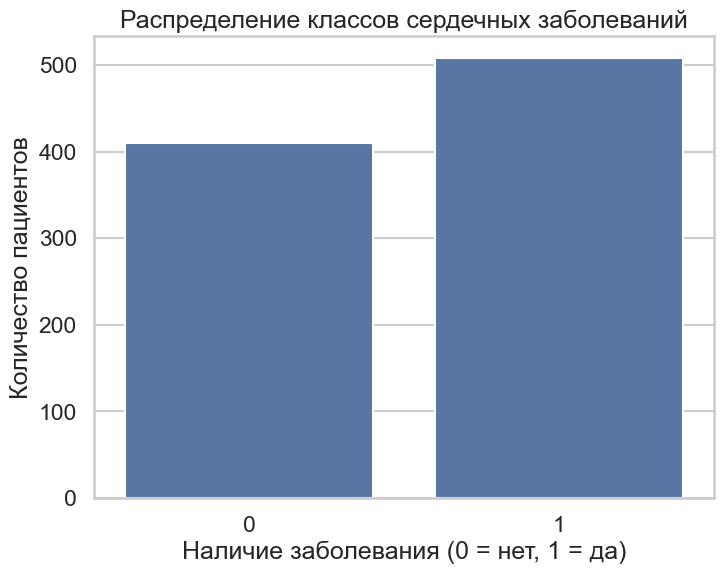


5. МАТРИЦА КОРРЕЛЯЦИИ ЧИСЛОВЫХ ПРИЗНАКОВ:


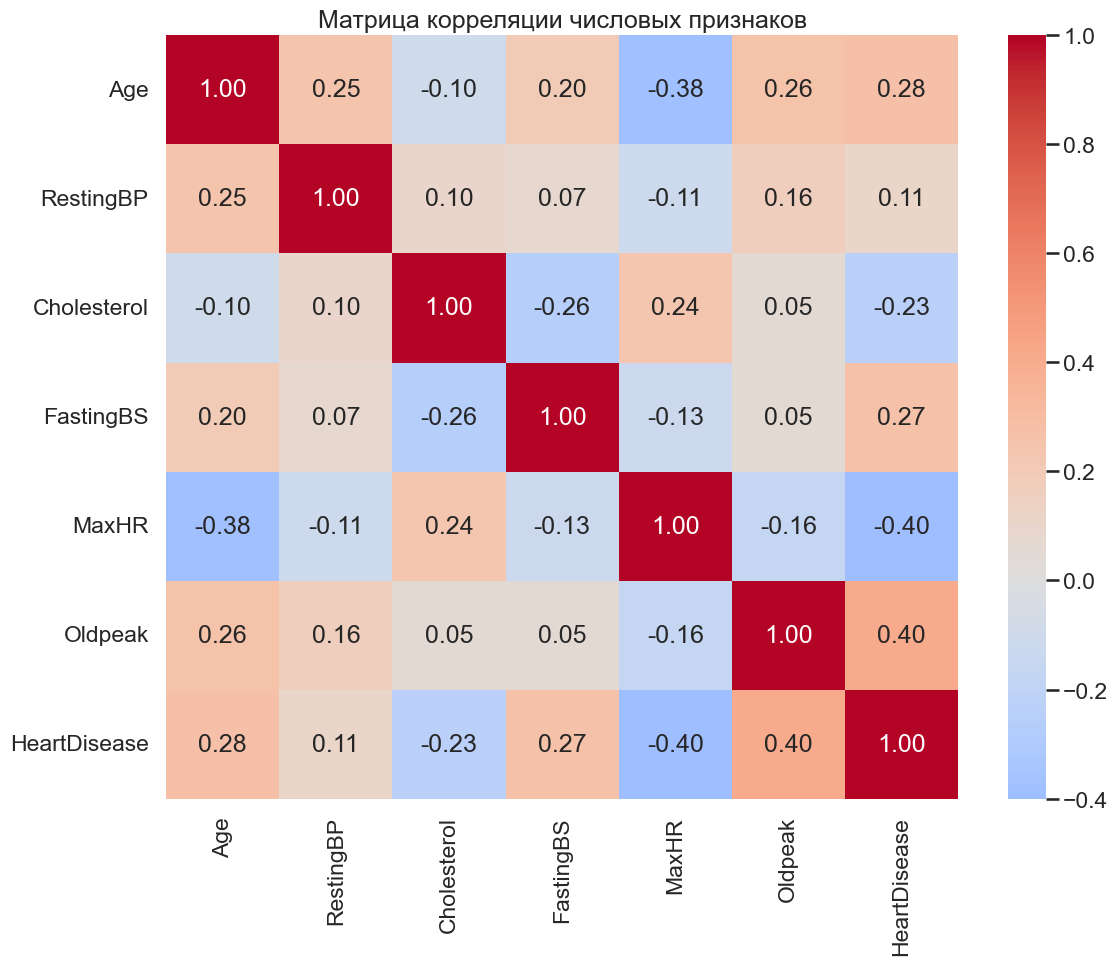

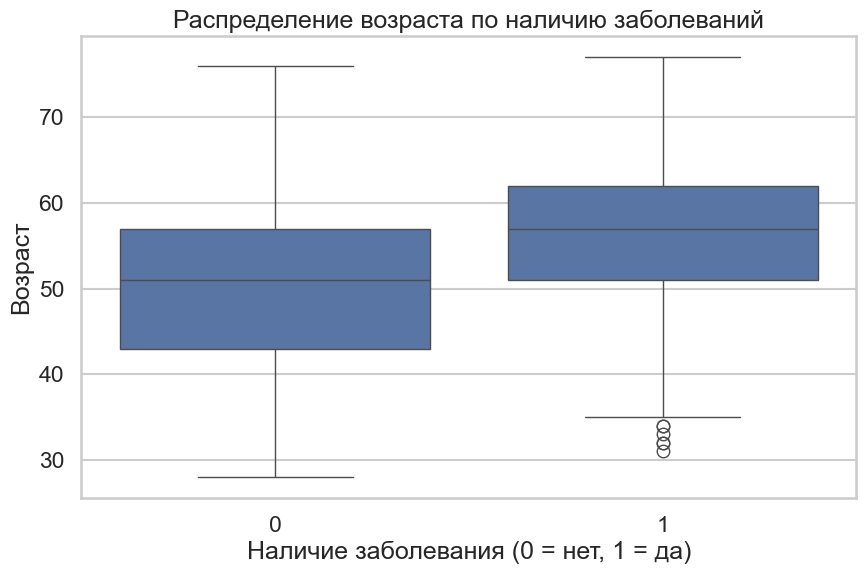

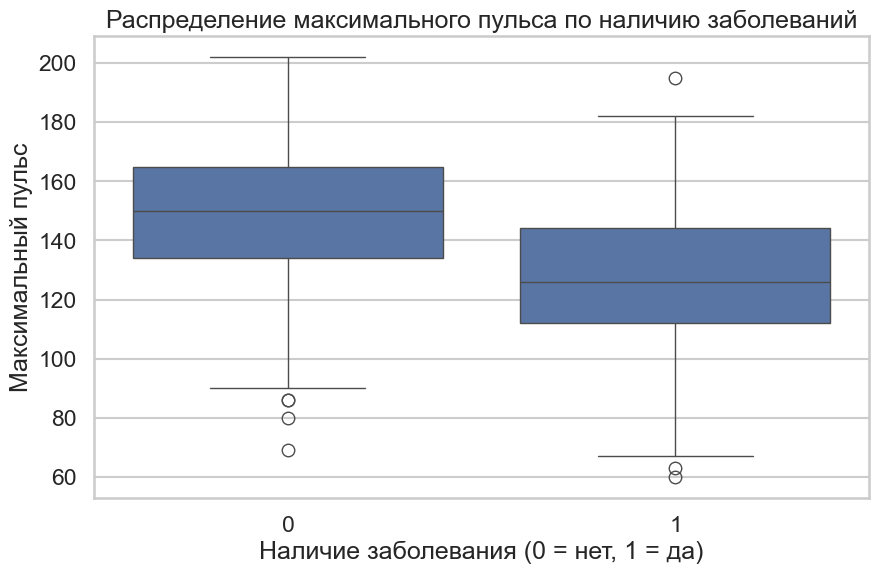

In [8]:
# ================================================================
# БЛОК 3. ПЕРВИЧНАЯ ДИАГНОСТИКА ДАННЫХ (EDA)
# ================================================================

print("=== ПЕРВИЧНАЯ ДИАГНОСТИКА ДАННЫХ ===\n")

# Проверка пропусков
print("1. ПРОВЕРКА ПРОПУСКОВ:")
print(heart_dataframe.isna().sum())

# Разделение признаков по типам
numeric_columns = heart_dataframe[feature_columns].select_dtypes(include="number").columns.tolist()
categorical_columns = heart_dataframe[feature_columns].select_dtypes(exclude="number").columns.tolist()

print(f"\n2. ТИПЫ ПРИЗНАКОВ:")
print("Числовые признаки:", numeric_columns)
print("Категориальные признаки:", categorical_columns)

# Базовая статистика по числовым признакам
print("\n3. БАЗОВАЯ СТАТИСТИКА (числовые признаки):")
stats_table = (
    heart_dataframe[numeric_columns]
    .describe()
    .T[["mean", "std", "min", "max"]]
    .round(2)
)
stats_table = stats_table.rename(
    columns={
        "mean": "mean (среднее)",
        "std": "std (стандартное отклонение)",
        "min": "min (минимум)",
        "max": "max (максимум)"
    }
)
print(stats_table)

# Распределение целевой переменной
print("\n4. РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ:")
target_distribution = heart_dataframe[target_column].value_counts(normalize=True).round(3)
print(target_distribution)

# Визуализация распределения классов
plt.figure(figsize=(8, 6))
sns.countplot(data=heart_dataframe, x=target_column)
plt.title("Распределение классов сердечных заболеваний")
plt.xlabel("Наличие заболевания (0 = нет, 1 = да)")
plt.ylabel("Количество пациентов")
plt.show()

# Визуализация корреляции числовых признаков
print("\n5. МАТРИЦА КОРРЕЛЯЦИИ ЧИСЛОВЫХ ПРИЗНАКОВ:")
plt.figure(figsize=(12, 10))
correlation_matrix = heart_dataframe[numeric_columns + [target_column]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Матрица корреляции числовых признаков")
plt.tight_layout()
plt.show()

# Визуализация распределения возраста по классам
plt.figure(figsize=(10, 6))
sns.boxplot(data=heart_dataframe, x=target_column, y='Age')
plt.title("Распределение возраста по наличию заболеваний")
plt.xlabel("Наличие заболевания (0 = нет, 1 = да)")
plt.ylabel("Возраст")
plt.show()

# Визуализация максимального пульса по классам
plt.figure(figsize=(10, 6))
sns.boxplot(data=heart_dataframe, x=target_column, y='MaxHR')
plt.title("Распределение максимального пульса по наличию заболеваний")
plt.xlabel("Наличие заболевания (0 = нет, 1 = да)")
plt.ylabel("Максимальный пульс")
plt.show()

In [9]:
# ================================================================
# БЛОК 4. ПОДГОТОВКА ДАННЫХ
# ================================================================

print("=== ПОДГОТОВКА ДАННЫХ ===\n")

# Проверка пропусков перед обработкой
print("Пропуски до обработки:")
print(heart_dataframe[feature_columns + [target_column]].isna().sum())

# Так как пропусков нет, мы можем сразу работать с данными
prepared_dataframe = heart_dataframe[feature_columns + [target_column]].copy()

print(f"Размер данных после подготовки: {prepared_dataframe.shape}")
print("Осталось пропусков:", int(prepared_dataframe.isna().sum().sum()))

# Разделение на признаки и целевую переменную
X = prepared_dataframe[feature_columns].copy()
y = prepared_dataframe[target_column].copy()

print(f"\nФорма X: {X.shape}")
print(f"Форма y: {y.shape}")

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y,
    random_state=42
)

print(f"\nРАЗДЕЛЕНИЕ НА TRAIN/TEST:")
print(f"X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"y_train: {y_train.shape} | y_test: {y_test.shape}")

# Проверка баланса классов
print("\nБАЛАНС КЛАССОВ:")
print("y_train:")
print(y_train.value_counts(normalize=True).round(3))
print("\ny_test:")
print(y_test.value_counts(normalize=True).round(3))

=== ПОДГОТОВКА ДАННЫХ ===

Пропуски до обработки:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Размер данных после подготовки: (918, 12)
Осталось пропусков: 0

Форма X: (918, 11)
Форма y: (918,)

РАЗДЕЛЕНИЕ НА TRAIN/TEST:
X_train: (642, 11) | X_test: (276, 11)
y_train: (642,) | y_test: (276,)

БАЛАНС КЛАССОВ:
y_train:
HeartDisease
1    0.553
0    0.447
Name: proportion, dtype: float64

y_test:
HeartDisease
1    0.554
0    0.446
Name: proportion, dtype: float64


In [10]:
# ================================================================
# БЛОК 5. ПОДГОТОВКА ПРИЗНАКОВ И БАЗОВАЯ МОДЕЛЬ
# ================================================================

print("=== ПОДГОТОВКА ПРИЗНАКОВ И БАЗОВАЯ МОДЕЛЬ ===\n")

# Обновляем списки числовых и категориальных признаков для train данных
numeric_columns = X_train.select_dtypes(include="number").columns.tolist()
categorical_columns = X_train.select_dtypes(exclude="number").columns.tolist()

print("Числовые признаки:", numeric_columns)
print("Категориальные признаки:", categorical_columns)

# Создаем препроцессор
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("scale_numeric", numeric_transformer, numeric_columns),
        ("onehot_categorical", categorical_transformer, categorical_columns),
    ],
    remainder="drop"
)

# Демонстрация трансформации данных
print("\nДЕМОНСТРАЦИЯ ПРЕОБРАЗОВАНИЯ ПРИЗНАКОВ:")
print("Форма данных до трансформации:", X_train.shape)

# Применяем препроцессинг к train данным
X_train_transformed = preprocessor.fit_transform(X_train)
print("Форма данных после трансформации:", X_train_transformed.shape)

# Получаем имена фичей после преобразования
feature_names = numeric_columns.copy()
fitted_ohe = preprocessor.named_transformers_["onehot_categorical"]
ohe_feature_names = fitted_ohe.get_feature_names_out(categorical_columns)
feature_names.extend(ohe_feature_names)

print(f"Общее количество признаков после преобразования: {len(feature_names)}")
print("Примеры новых признаков:", feature_names[:10])

=== ПОДГОТОВКА ПРИЗНАКОВ И БАЗОВАЯ МОДЕЛЬ ===

Числовые признаки: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Категориальные признаки: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

ДЕМОНСТРАЦИЯ ПРЕОБРАЗОВАНИЯ ПРИЗНАКОВ:
Форма данных до трансформации: (642, 11)
Форма данных после трансформации: (642, 20)
Общее количество признаков после преобразования: 20
Примеры новых признаков: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA']


=== ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ ===

=== МОДЕЛЬ 1: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ===
Accuracy: 0.884
F1-macro: 0.882

Classification Report:
              precision    recall  f1-score   support

           0      0.896     0.837     0.866       123
           1      0.876     0.922     0.898       153

    accuracy                          0.884       276
   macro avg      0.886     0.879     0.882       276
weighted avg      0.885     0.884     0.884       276



<Figure size 600x500 with 0 Axes>

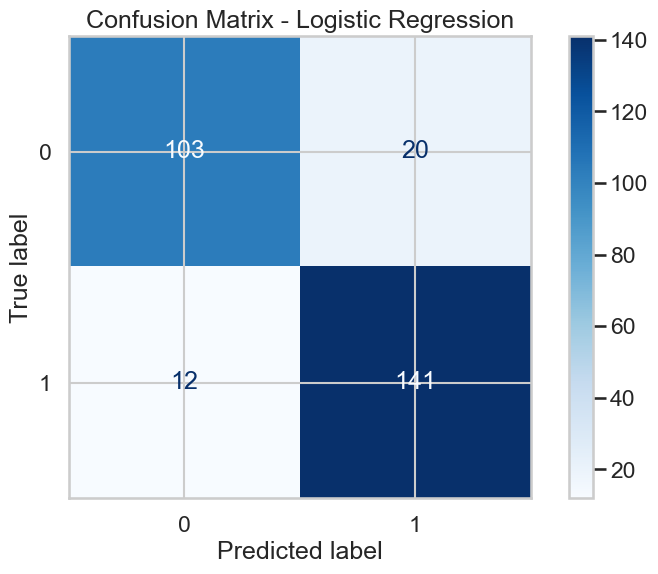

In [11]:
# ================================================================
# БЛОК 6. ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ
# ================================================================

print("=== ОБУЧЕНИЕ И ОЦЕНКА МОДЕЛЕЙ ===\n")

# МОДЕЛЬ 1: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ
print("=== МОДЕЛЬ 1: ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ===")

logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", logreg_model)
])

# Обучение модели
logreg_pipeline.fit(X_train, y_train)

# Предсказания
y_pred_logreg = logreg_pipeline.predict(X_test)

# Метрики
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg, average="macro")

print(f"Accuracy: {accuracy_logreg:.3f}")
print(f"F1-macro: {f1_logreg:.3f}")

# Детальный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg, digits=3))

# Матрица ошибок
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg, cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


=== МОДЕЛЬ 2: K-БЛИЖАЙШИХ СОСЕДЕЙ (KNN) ===
Accuracy: 0.880
F1-macro: 0.879

Classification Report:
              precision    recall  f1-score   support

           0      0.875     0.854     0.864       123
           1      0.885     0.902     0.893       153

    accuracy                          0.880       276
   macro avg      0.880     0.878     0.879       276
weighted avg      0.880     0.880     0.880       276



<Figure size 600x500 with 0 Axes>

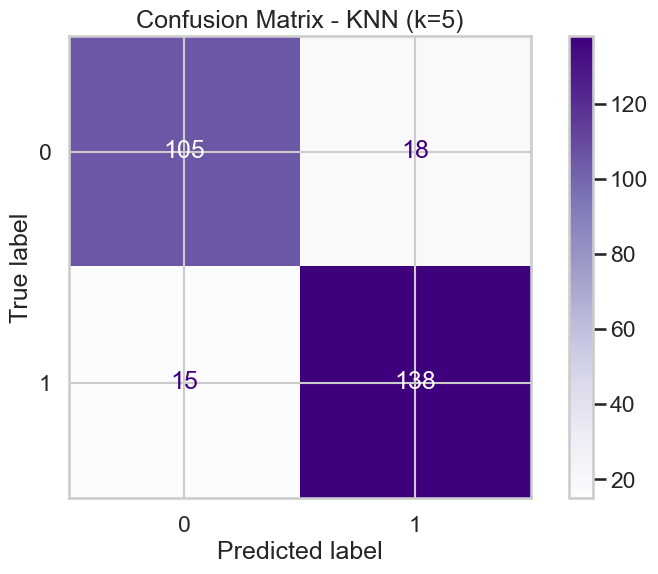

In [12]:
# МОДЕЛЬ 2: K-БЛИЖАЙШИХ СОСЕДЕЙ
print("\n=== МОДЕЛЬ 2: K-БЛИЖАЙШИХ СОСЕДЕЙ (KNN) ===")

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", knn_model)
])

# Обучение модели
knn_pipeline.fit(X_train, y_train)

# Предсказания
y_pred_knn = knn_pipeline.predict(X_test)

# Метрики
accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average="macro")

print(f"Accuracy: {accuracy_knn:.3f}")
print(f"F1-macro: {f1_knn:.3f}")

# Детальный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, digits=3))

# Матрица ошибок
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, cmap="Purples")
plt.title("Confusion Matrix - KNN (k=5)")
plt.show()


=== МОДЕЛЬ 3: ДЕРЕВО РЕШЕНИЙ ===
Accuracy: 0.819
F1-macro: 0.818

Classification Report:
              precision    recall  f1-score   support

           0      0.779     0.829     0.803       123
           1      0.855     0.810     0.832       153

    accuracy                          0.819       276
   macro avg      0.817     0.820     0.818       276
weighted avg      0.821     0.819     0.819       276



<Figure size 600x500 with 0 Axes>

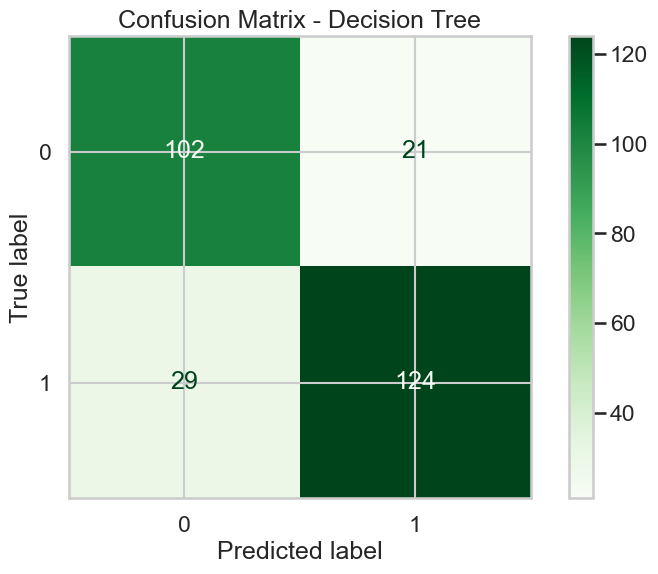

In [13]:
# МОДЕЛЬ 3: ДЕРЕВО РЕШЕНИЙ
print("\n=== МОДЕЛЬ 3: ДЕРЕВО РЕШЕНИЙ ===")

tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("clf", tree_model)
])

# Обучение модели
tree_pipeline.fit(X_train, y_train)

# Предсказания
y_pred_tree = tree_pipeline.predict(X_test)

# Метрики
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree, average="macro")

print(f"Accuracy: {accuracy_tree:.3f}")
print(f"F1-macro: {f1_tree:.3f}")

# Детальный отчет
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree, digits=3))

# Матрица ошибок
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree, cmap="Greens")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

=== СРАВНЕНИЕ МОДЕЛЕЙ ===

СРАВНЕНИЕ МЕТРИК:
                 Model  Accuracy  F1-macro
0  Logistic Regression     0.884     0.882
1                  KNN     0.880     0.879
2        Decision Tree     0.819     0.818


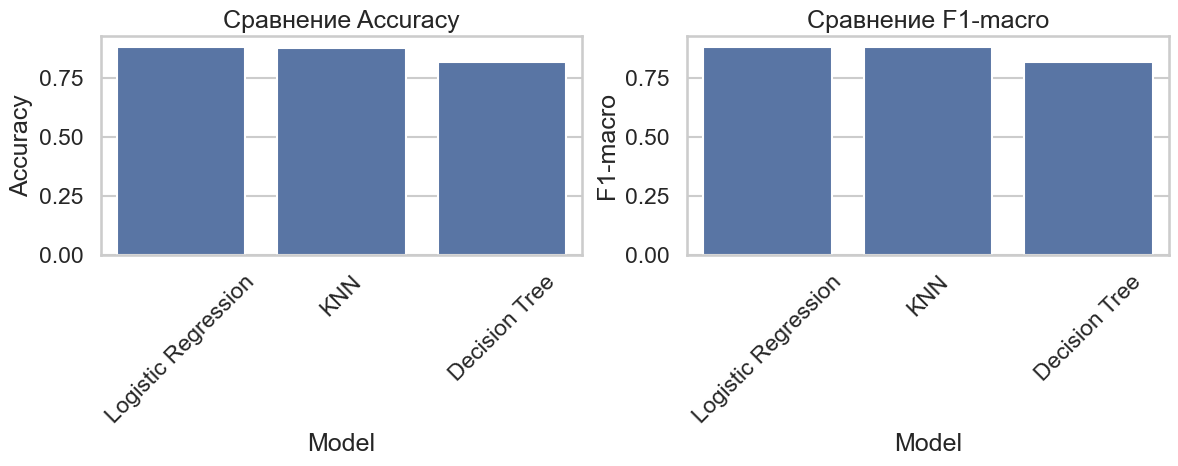

In [17]:
# ================================================================
# БЛОК 7. СРАВНЕНИЕ МОДЕЛЕЙ
# ================================================================

print("=== СРАВНЕНИЕ МОДЕЛЕЙ ===\n")

# Создаем таблицу сравнения
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree'],
    'Accuracy': [accuracy_logreg, accuracy_knn, accuracy_tree],
    'F1-macro': [f1_logreg, f1_knn, f1_tree]
})

print("СРАВНЕНИЕ МЕТРИК:")
print(comparison_df.round(3))

# Визуализация сравнения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# График Accuracy
sns.barplot(data=comparison_df, x='Model', y='Accuracy', ax=ax1)
ax1.set_title('Сравнение Accuracy')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)

# График F1-macro
sns.barplot(data=comparison_df, x='Model', y='F1-macro', ax=ax2)
ax2.set_title('Сравнение F1-macro')
ax2.set_ylabel('F1-macro')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

=== ЭКСПЕРИМЕНТЫ С ПАРАМЕТРАМИ ===

ЭКСПЕРИМЕНТ 1: ВЛИЯНИЕ ПАРАМЕТРА k НА КАЧЕСТВО KNN
k=3: Accuracy=0.873, F1-macro=0.871
k=5: Accuracy=0.880, F1-macro=0.879
k=7: Accuracy=0.906, F1-macro=0.904
k=9: Accuracy=0.895, F1-macro=0.893
k=11: Accuracy=0.902, F1-macro=0.901


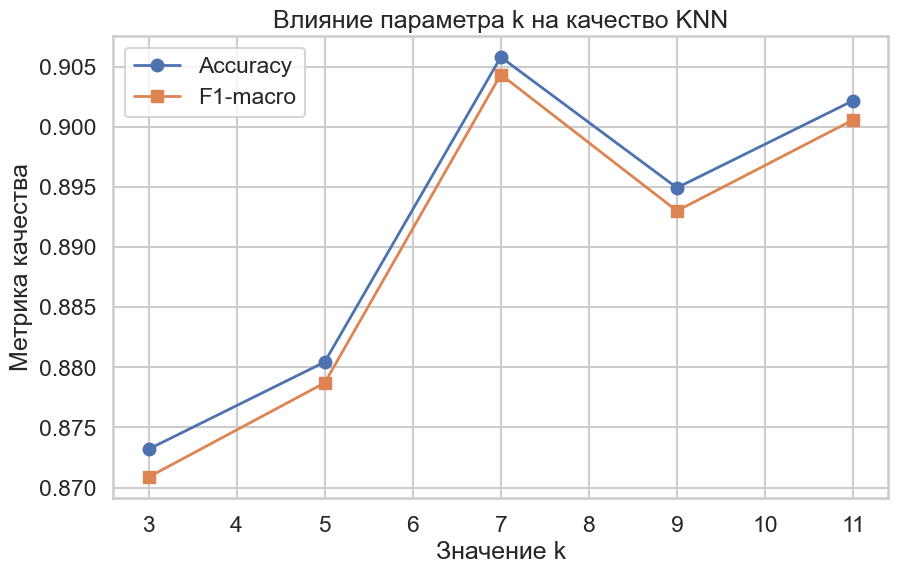

In [18]:
# ================================================================
# БЛОК 8. ЭКСПЕРИМЕНТЫ С ПАРАМЕТРАМИ
# ================================================================

print("=== ЭКСПЕРИМЕНТЫ С ПАРАМЕТРАМИ ===\n")

# Эксперимент 1: Разные значения k для KNN
print("ЭКСПЕРИМЕНТ 1: ВЛИЯНИЕ ПАРАМЕТРА k НА КАЧЕСТВО KNN")

k_values = [3, 5, 7, 9, 11]
knn_accuracies = []
knn_f1_scores = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp_pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("clf", knn_temp)
    ])
    knn_temp_pipeline.fit(X_train, y_train)
    y_pred_temp = knn_temp_pipeline.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_temp)
    f1 = f1_score(y_test, y_pred_temp, average="macro")
    
    knn_accuracies.append(acc)
    knn_f1_scores.append(f1)
    print(f"k={k}: Accuracy={acc:.3f}, F1-macro={f1:.3f}")

# Визуализация влияния k
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_accuracies, marker='o', label='Accuracy', linewidth=2)
plt.plot(k_values, knn_f1_scores, marker='s', label='F1-macro', linewidth=2)
plt.xlabel('Значение k')
plt.ylabel('Метрика качества')
plt.title('Влияние параметра k на качество KNN')
plt.legend()
plt.grid(True)
plt.show()


ЭКСПЕРИМЕНТ 2: ВЛИЯНИЕ ГЛУБИНЫ ДЕРЕВА НА КАЧЕСТВО
max_depth=3: Accuracy=0.848, F1-macro=0.847
max_depth=5: Accuracy=0.819, F1-macro=0.818
max_depth=7: Accuracy=0.812, F1-macro=0.810
max_depth=10: Accuracy=0.833, F1-macro=0.832
max_depth=15: Accuracy=0.822, F1-macro=0.821
max_depth=None: Accuracy=0.822, F1-macro=0.821


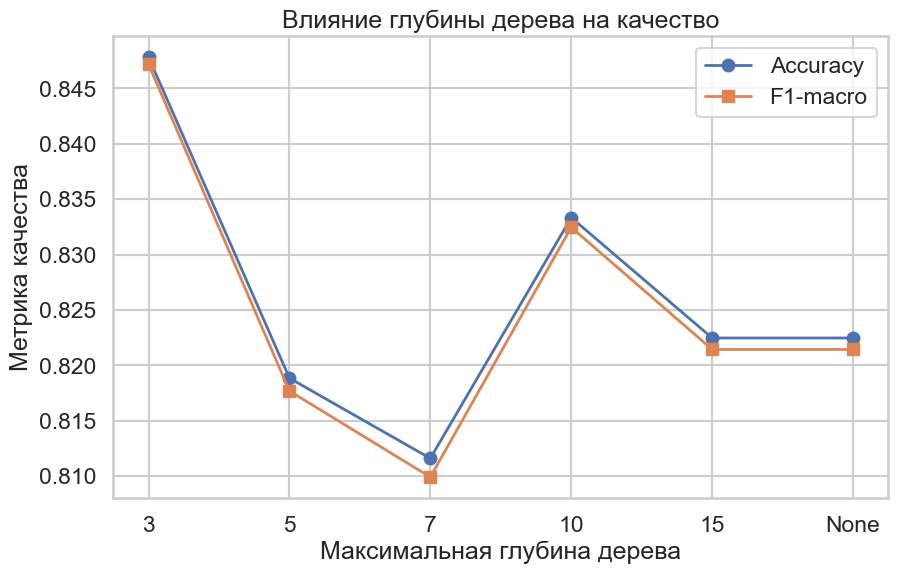

In [19]:
# Эксперимент 2: Разная глубина дерева
print("\nЭКСПЕРИМЕНТ 2: ВЛИЯНИЕ ГЛУБИНЫ ДЕРЕВА НА КАЧЕСТВО")

depth_values = [3, 5, 7, 10, 15, None]
tree_accuracies = []
tree_f1_scores = []

for depth in depth_values:
    tree_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree_temp_pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("clf", tree_temp)
    ])
    tree_temp_pipeline.fit(X_train, y_train)
    y_pred_temp = tree_temp_pipeline.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_temp)
    f1 = f1_score(y_test, y_pred_temp, average="macro")
    
    tree_accuracies.append(acc)
    tree_f1_scores.append(f1)
    depth_str = "None" if depth is None else str(depth)
    print(f"max_depth={depth_str}: Accuracy={acc:.3f}, F1-macro={f1:.3f}")

# Визуализация влияния глубины
plt.figure(figsize=(10, 6))
depth_labels = [str(d) if d is not None else "None" for d in depth_values]
x_positions = range(len(depth_labels))

plt.plot(x_positions, tree_accuracies, marker='o', label='Accuracy', linewidth=2)
plt.plot(x_positions, tree_f1_scores, marker='s', label='F1-macro', linewidth=2)
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Метрика качества')
plt.title('Влияние глубины дерева на качество')
plt.xticks(x_positions, depth_labels)
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Эксперимент 3: Влияние удаления признаков
print("\nЭКСПЕРИМЕНТ 3: ВЛИЯНИЕ УДАЛЕНИЯ ПРИЗНАКОВ")
# Выберем несколько важных признаков на основе корреляции
important_features = ['Age', 'RestingBP', 'FastingBS', 'Oldpeak', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
results_removal = []

for feature_to_remove in important_features:
    # Создаем копию признаков без одного признака
    features_without_one = [f for f in feature_columns if f != feature_to_remove]
    
    X_train_reduced = X_train[features_without_one].copy()
    X_test_reduced = X_test[features_without_one].copy()
    
    # Пересоздаем препроцессор для уменьшенного набора признаков
    numeric_columns_reduced = X_train_reduced.select_dtypes(include="number").columns.tolist()
    categorical_columns_reduced = X_train_reduced.select_dtypes(exclude="number").columns.tolist()
    
    preprocessor_reduced = ColumnTransformer(
        transformers=[
            ("scale_numeric", StandardScaler(), numeric_columns_reduced),
            ("onehot_categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns_reduced),
        ],
        remainder="drop"
    )
    
    # Обучаем логистическую регрессию
    logreg_temp = LogisticRegression(max_iter=1000, random_state=42)
    pipeline_temp = Pipeline([
        ("preprocess", preprocessor_reduced),
        ("clf", logreg_temp)
    ])
    
    pipeline_temp.fit(X_train_reduced, y_train)
    y_pred_temp = pipeline_temp.predict(X_test_reduced)
    
    acc = accuracy_score(y_test, y_pred_temp)
    results_removal.append({
        'removed_feature': feature_to_remove,
        'accuracy': acc,
        'difference': acc - accuracy_logreg
    })
    
    print(f"Без признака '{feature_to_remove}': Accuracy={acc:.3f}, Изменение={acc - accuracy_logreg:+.3f}")

# Сравнение с исходной точностью
print(f"\nИсходная точность (все признаки): {accuracy_logreg:.3f}")


ЭКСПЕРИМЕНТ 3: ВЛИЯНИЕ УДАЛЕНИЯ ПРИЗНАКОВ
Без признака 'Age': Accuracy=0.884, Изменение=+0.000
Без признака 'RestingBP': Accuracy=0.884, Изменение=+0.000
Без признака 'FastingBS': Accuracy=0.880, Изменение=-0.004
Без признака 'Oldpeak': Accuracy=0.870, Изменение=-0.014
Без признака 'ChestPainType': Accuracy=0.873, Изменение=-0.011
Без признака 'RestingECG': Accuracy=0.891, Изменение=+0.007
Без признака 'ExerciseAngina': Accuracy=0.862, Изменение=-0.022
Без признака 'ST_Slope': Accuracy=0.833, Изменение=-0.051

Исходная точность (все признаки): 0.884


=== КРОСС-ВАЛИДАЦИЯ ===

Выполнение кросс-валидации для Logistic Regression...
Logistic Regression:
  Accuracy: 0.829 ± 0.033
  F1-macro: 0.826 ± 0.033

Выполнение кросс-валидации для KNN...
KNN:
  Accuracy: 0.837 ± 0.044
  F1-macro: 0.834 ± 0.043

Выполнение кросс-валидации для Decision Tree...
Decision Tree:
  Accuracy: 0.801 ± 0.044
  F1-macro: 0.796 ± 0.046

СРАВНЕНИЕ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ:
                 Model  CV Accuracy  CV F1-macro
0  Logistic Regression        0.829        0.826
1                  KNN        0.837        0.834
2        Decision Tree        0.801        0.796


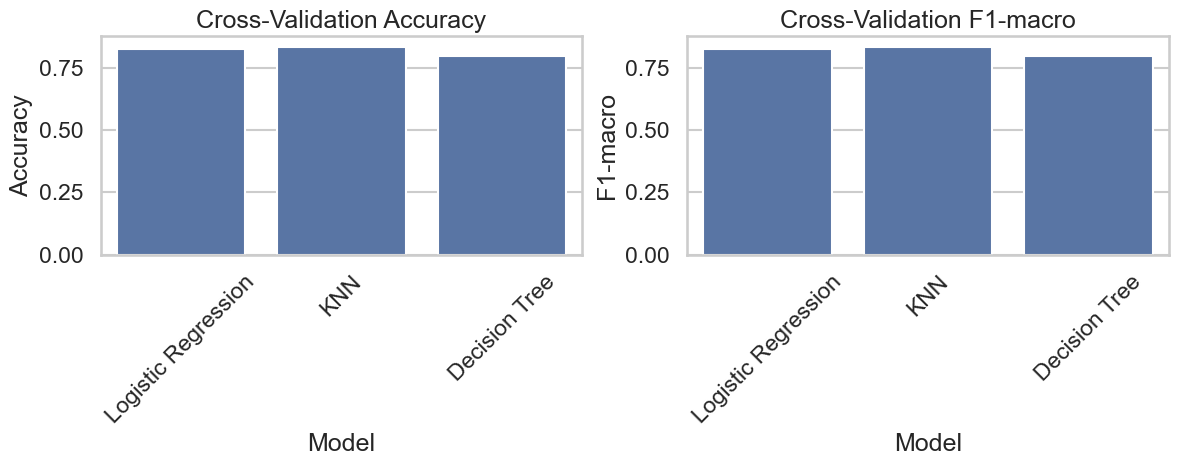

In [24]:
# ================================================================
# БЛОК 9. КРОСС-ВАЛИДАЦИЯ
# ================================================================

print("=== КРОСС-ВАЛИДАЦИЯ ===\n")

from sklearn.model_selection import cross_val_score

# Кросс-валидация для всех моделей
models = {
    'Logistic Regression': logreg_pipeline,
    'KNN': knn_pipeline, 
    'Decision Tree': tree_pipeline
}

cv_results = {}

for model_name, model_pipeline in models.items():
    print(f"Выполнение кросс-валидации для {model_name}...")
    
    # Кросс-валидация по Accuracy
    cv_accuracy = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
    
    # Кросс-валидация по F1-macro
    cv_f1 = cross_val_score(model_pipeline, X, y, cv=5, scoring='f1_macro')
    
    cv_results[model_name] = {
        'cv_accuracy_mean': cv_accuracy.mean(),
        'cv_accuracy_std': cv_accuracy.std(),
        'cv_f1_mean': cv_f1.mean(),
        'cv_f1_std': cv_f1.std()
    }
    
    print(f"{model_name}:")
    print(f"  Accuracy: {cv_accuracy.mean():.3f} ± {cv_accuracy.std():.3f}")
    print(f"  F1-macro: {cv_f1.mean():.3f} ± {cv_f1.std():.3f}")
    print()

# Визуализация результатов кросс-валидации
cv_comparison = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'CV Accuracy': [result['cv_accuracy_mean'] for result in cv_results.values()],
    'CV F1-macro': [result['cv_f1_mean'] for result in cv_results.values()]
})

print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ:")
print(cv_comparison.round(3))

# График сравнения кросс-валидации
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
sns.barplot(data=cv_comparison, x='Model', y='CV Accuracy', ax=ax1)
ax1.set_title('Cross-Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)

# F1-macro
sns.barplot(data=cv_comparison, x='Model', y='CV F1-macro', ax=ax2)
ax2.set_title('Cross-Validation F1-macro')
ax2.set_ylabel('F1-macro')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [28]:
print("=== ВЫВОДЫ И ЗАКЛЮЧЕНИЕ ===\n")

print("1. КАКАЯ МОДЕЛЬ ЛУЧШЕ РАБОТАЕТ?")
best_model_idx = comparison_df['Accuracy'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Accuracy']
print(f"   - Лучшая модель: {best_model} с Accuracy = {best_accuracy:.3f}")

print("\n2. ВАЖНЫЕ ПРИЗНАКИ:")
print("   На основе анализа корреляции и экспериментов с удалением признаков:")
print("   - ST_Slope (наклон сегмента ST) - сильнее всех влияет на точность")
print("   Так же влияют на точность")
print("   - ExerciseAngina (стенокардия при нагрузке)")
print("   - Oldpeak (депрессия ST)")
print("   - ChestPainType (тип боли в груди)")
print("   - RestingECG (результаты ЭКГ в покое)")  

print("\n3. АНАЛИЗ ОШИБОК:")
print("   - Модели в основном путают пациентов с пограничными показателями")
print("   - Logistic Regression показала лучший результат")

print("\n4. ОБЩИЙ ВЫВОД:")
print("   Все три модели показывают хорошее качество (>80% accuracy)")
print("   Задача хорошо решается методами машинного обучения")
print("   Однако для медицины такой точности недостаточно")
print("   Модели могут быть полезны для предварительной диагностики")

=== ВЫВОДЫ И ЗАКЛЮЧЕНИЕ ===

1. КАКАЯ МОДЕЛЬ ЛУЧШЕ РАБОТАЕТ?
   - Лучшая модель: Logistic Regression с Accuracy = 0.884

2. ВАЖНЫЕ ПРИЗНАКИ:
   На основе анализа корреляции и экспериментов с удалением признаков:
   - ST_Slope (наклон сегмента ST) - сильнее всех влияет на точность
   Так же влияют на точность
   - ExerciseAngina (стенокардия при нагрузке)
   - Oldpeak (депрессия ST)
   - ChestPainType (тип боли в груди)
   - RestingECG (результаты ЭКГ в покое)

3. АНАЛИЗ ОШИБОК:
   - Модели в основном путают пациентов с пограничными показателями
   - Logistic Regression показала лучший результат

4. ОБЩИЙ ВЫВОД:
   Все три модели показывают хорошее качество (>80% accuracy)
   Задача хорошо решается методами машинного обучения
   Однако для медицины такой точности недостаточно
   Модели могут быть полезны для предварительной диагностики
